# Objective- Logistic Regression on Amazon fine food reviews (Bag of Words)

#### Codes for-
* GridSearchCV and RandomSearchCV to find optimal lambda
* l1 and l2 regularizer
* feature importance
* by increasing lambda using 'l1' regularizer, the change occurs in the result


#### About the data-
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [6]:
sql=sqlite3.connect('database.sqlite')  #loading sql data
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql)

In [7]:
data.columns  #column names in the dataset

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
#for changing score int value to positive (1) and negative (0) i.e only in two class
def posneg(x):
    if x<3:
        return 0
    else:
        return 1
score=data['Score']
data['Score']=score.map(posneg)

In [9]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data cleaning

In [10]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']] 

In [11]:
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True) #droping the duplicates
data.shape

(364171, 10)

In [12]:
import nltk
from nltk.corpus import stopwords

In [13]:
stop=set(stopwords.words('english'))

In [14]:

sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [70]:
#taking sample of data
sample=data.sample(100000)
sample_data=sample.sort_values(['Time'])  #sorting data on time basis
sample_score=sample_data['Score']

In [71]:
#filtering sentence
import re
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [72]:
sample_data['Cleaned_text']=final_string  #creating a new column in sample_data

In [73]:
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni keaton hilari wacki g...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri love cal...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,b'sick scad nasti toothpick counter tint conce...


In [74]:
sample_data['Score'].value_counts()

1    84317
0    15683
Name: Score, dtype: int64

In [75]:
sample_data['Score'].value_counts()

1    84317
0    15683
Name: Score, dtype: int64

In [76]:
#taking the test data seperate from all other

train,test=train_test_split(sample_data,test_size=0.3) #splitting the data

In [77]:
train['Score'].value_counts()

1    59067
0    10933
Name: Score, dtype: int64

In [78]:
test['Score'].value_counts()

1    25250
0     4750
Name: Score, dtype: int64

In [79]:
from sklearn.utils import resample

In [80]:
df_majority = train[train['Score']==1]
df_minority = train[train['Score']==0]


In [81]:
#upsampling on train data
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=59067,    # to match majority class
                                 random_state=123) # reproducible results


In [82]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Score'].value_counts()

1    59067
0    59067
Name: Score, dtype: int64

In [219]:
df_upsampled=df_upsampled.sort_values(['Time'])

X=df_upsampled['Cleaned_text']
y_train=df_upsampled['Score']

In [84]:
# universal x_test and y_test 
x_test=test['Cleaned_text']
y_test=test['Score']

In [2]:
import pandas as pd
results=pd.DataFrame(columns=['sno.', 'featurization', 'n_gram range', 'model' ,'cv algo', 'best penalty', 'class_weight', 'best C', 'accuracy', 'AUC', 'TNR', 'TPR', 'FPR', 'FNR'])

In [85]:
def logistic_regression(clf, x_train, y_train, x_test, y_test):
    #plot error vs C
    x_1=[]
    x_2=[]
    y_1=[]
    y_2=[]
    for x in clf.grid_scores_:
        if(x[0]['penalty']=='l1'):
            x_1.append(x[0]['C'])
            y_1.append(1-x[1])
        else:
            x_2.append(x[0]['C'])
            y_2.append(1-x[1])
    plt.plot(x_1,y_1, label='l1')
    plt.plot(x_2,y_2, label='l2')
    plt.xlabel('value of C')
    plt.ylabel('misclassification error')
    plt.title('C vs error')
    plt.legend()
    plt.show()
    print('**********************************************************************\n')
      
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    #print('ROC curve--')
    y_pred_proba=clf.predict_proba(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.plot([0,1],[0,1],linestyle='--')
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.show()
    
    return accu, auc, TNR, TPR, FPR, FNR

# 1. Logistic Regression for Bag of words

###  Logistic regression for Bag of words using GridSearchCV 

In [31]:
count_vect=CountVectorizer()
x_train_bow=count_vect.fit_transform(X.values)

In [32]:
x_test_bow=count_vect.transform(x_test.values)

In [33]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


In [90]:
import seaborn as sns
from sklearn import metrics

In [35]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [36]:
import pickle

In [37]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
#pickle.dump(clf,open('bow_unigram.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 11.0min finished


duration =  0:11:01.047564


In [38]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 1
best penalty= l2


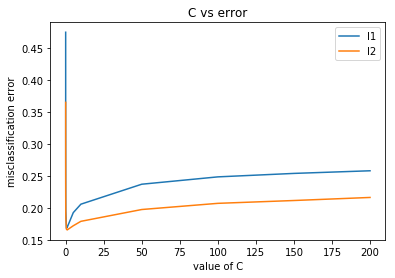

**********************************************************************

accuracy= 86.31333333333333
**********************************************************************

confusion matrix--


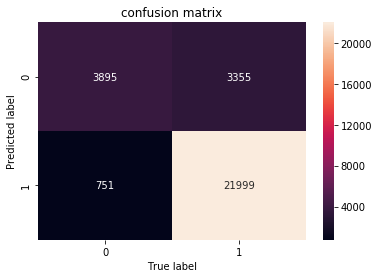

**********************************************************************

TNR= 0.8383555746879036
TPR= 0.8676737398438116
FPR= 0.16164442531209644
FNR= 0.13232626015618837
**********************************************************************

             precision    recall  f1-score   support

          0       0.84      0.54      0.65      7250
          1       0.87      0.97      0.91     22750

avg / total       0.86      0.86      0.85     30000

**********************************************************************



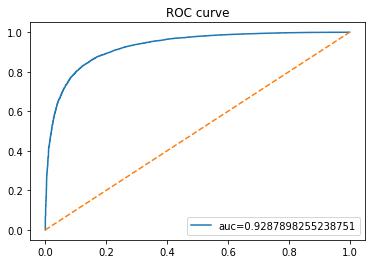

In [39]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_bow, y_train=y_train, x_test=x_test_bow, y_test=y_test)

In [40]:
new=[1,'Bag of words', 'unigram', 'LogisticRegression','GridSearchCV',penalty, 'None', c, accu, auc, TNR, TPR, FPR, FNR]
results.loc[0]=new

In [41]:
results

,sno.,featurization,n_gram range,model,cv algo,best penalty,class_weight,best C,accuracy,AUC,TNR,TPR,FPR,FNR
0,1,Bag of words,unigram,LogisticRegression,GridSearchCV,l2,None,1,86.313333,0.92879,0.838356,0.867674,0.161644,0.132326


### Logistic regression for bow, RandomizedSearchCV

In [42]:
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [43]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_bow,y_train)
#pickle.dump(clf,open('bow_unigram_balance_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.0min finished


duration =  0:05:05.559136


In [44]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 1
best penalty= l2


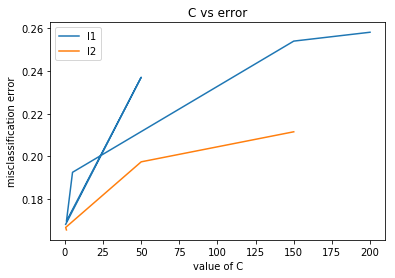

**********************************************************************

accuracy= 86.31333333333333
**********************************************************************

confusion matrix--


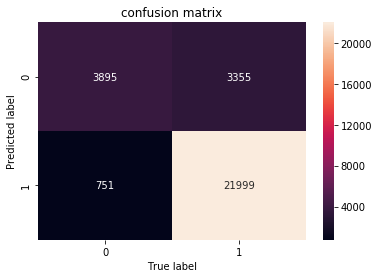

**********************************************************************

TNR= 0.8383555746879036
TPR= 0.8676737398438116
FPR= 0.16164442531209644
FNR= 0.13232626015618837
**********************************************************************

             precision    recall  f1-score   support

          0       0.84      0.54      0.65      7250
          1       0.87      0.97      0.91     22750

avg / total       0.86      0.86      0.85     30000

**********************************************************************



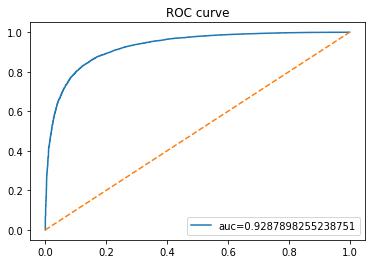

In [45]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_bow, y_train=y_train, x_test=x_test_bow, y_test=y_test)

In [46]:
new=[2,'Bag of words', 'unigram', 'LogisticRegression','RandomizedSearchCV',penalty, 'None', c, accu, auc, TNR, TPR, FPR, FNR]
results.loc[1]=new

In [47]:
results

,sno.,featurization,n_gram range,model,cv algo,best penalty,class_weight,best C,accuracy,AUC,TNR,TPR,FPR,FNR
0,1,Bag of words,unigram,LogisticRegression,GridSearchCV,l2,None,1,86.313333,0.92879,0.838356,0.867674,0.161644,0.132326
1,2,Bag of words,unigram,LogisticRegression,RandomizedSearchCV,l2,None,1,86.313333,0.92879,0.838356,0.867674,0.161644,0.132326


#### Observation-
* with C=1, and penalty='l2' we get good TNR, TPR, area under curve as well as accuracy

#### checking sparsity of bag of words by fixing penalty='l1' and changing C value

In [432]:
# this function takes C values and all inputs and plot the number of non zero elements in weight for every C

def sparsity(C, x_train, y_train, x_test, y_test):
    w_change=[]
    for i in C:
        clf=LogisticRegression(penalty='l1', C=i)
        clf.fit(x_train,y_train)
        accuracy=clf.predict(x_test)
        print('at C=',i)
        print('test error=',(1-accuracy_score(accuracy,y_test)))
        count=np.count_nonzero(clf.coef_)
        print('number of non zero element in w=', count)
        print('***********************************************')
        w_change.append(count)
        
        
    plt.figure(figsize=(6,6))
    plt.plot(C,w_change,color='green')
    plt.title('change in non zero element in W , when C changes')
    plt.xlabel('value of C')
    plt.ylabel('number of non zero element in W')
    plt.show()
    return w_change
        

In [433]:
C= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200]


In [434]:
count_vect=CountVectorizer(ngram_range=(1,1))
x_train_bow=count_vect.fit_transform(X.values)
x_test_bow=count_vect.transform(x_test.values)

In [435]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


at C= 0.001
test error= 0.4914333333333334
number of non zero element in w= 2
***********************************************
at C= 0.005
test error= 0.3664666666666667
number of non zero element in w= 26
***********************************************
at C= 0.01
test error= 0.2823333333333333
number of non zero element in w= 60
***********************************************
at C= 0.05
test error= 0.19199999999999995
number of non zero element in w= 266
***********************************************
at C= 0.1
test error= 0.1697333333333333
number of non zero element in w= 464
***********************************************
at C= 0.5
test error= 0.14513333333333334
number of non zero element in w= 1480
***********************************************
at C= 1
test error= 0.1378666666666667
number of non zero element in w= 2417
***********************************************
at C= 5
test error= 0.12983333333333336
number of non zero element in w= 6130
************************************

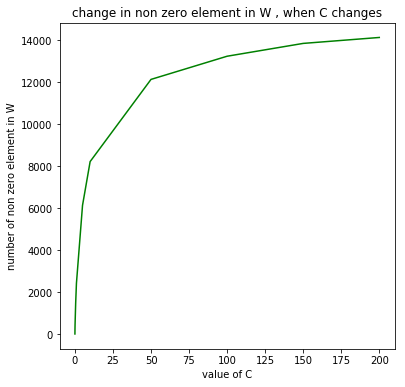

In [436]:
#calling the sparsity function
_=sparsity(C, x_train=x_train_bow, x_test=x_test_bow, y_train=y_train, y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

#### feature importance and multicollinearity for bag of words, using best C=1 and penalty='l2'

In [437]:
count_vect=CountVectorizer(ngram_range=(1,1))
x_train_bow=count_vect.fit_transform(X.values)
x_test_bow=count_vect.transform(x_test.values)

In [438]:
from sklearn.preprocessing import normalize

x_train_bow=normalize(x_train_bow)
x_test_bow=normalize(x_test_bow)


In [439]:
#computing weight before perturbation test
clf=LogisticRegression(C=1, penalty='l2')
clf.fit(x_train_bow,y_train)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 28021


In [440]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

x_train_bow.data=x_train_bow.data+np.random.normal(loc=0,scale=0.1,size=x_train_bow.data.shape)  #adding a noise with a very small value

In [442]:
#computing weight after perturbation weight
clf=LogisticRegression(C=1, penalty='l2')
clf.fit(x_train_bow,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 28021


In [454]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 14345


#### Observation-
* we have 28021 non zero elements in weight before perturbation and after perturbation weight
* after perturbation test, 14345 elements in weight before perturbation change by more than 50 %
* Thus we can say that half of the elements in weight are collinear
* Thus we can not find feature importance directly by coef_ of model

#### feature importance using RFE(recursive feature elimination)

In [ ]:
#https://machinelearningmastery.com/feature-selection-machine-learning-python/
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

In [332]:
from sklearn.feature_selection import RFE

In [479]:
%time
from sklearn.feature_selection import RFE
rfe = RFE(clf, 100, verbose=0, step=100)
fit = rfe.fit(x_train_bow,y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs


In [480]:
feature=count_vect.get_feature_names()
#feature[0]

In [481]:
rank=fit.ranking_
index=[]
for i in range(len(feature)):
    if(rank[i]==1):
        index.append(i)

In [484]:
print('top 100 words comes from RFE')
print('*********************************')
for i in range(100):
    print(feature[index[i]],'\t\t:\t\t',w[0][index[i]])

top 100 words comes from RFE
*********************************
addict 		:		 5.449493247179106
amaz 		:		 6.588976895779909
assum 		:		 -2.6468362129037493
aw 		:		 -6.681625663137706
awesom 		:		 6.106386265606328
bad 		:		 -3.0344895994510432
balanc 		:		 3.113407851287748
bare 		:		 -4.273956974408792
beat 		:		 4.390984946654834
best 		:		 6.139948651003783
bewar 		:		 -3.3647286353963364
bland 		:		 -6.01064420255473
cancel 		:		 -5.036189214019031
china 		:		 -4.2845266909644195
contact 		:		 -2.0488545206108593
delici 		:		 6.7459533615351965
descript 		:		 -4.0579828733468615
disappoint 		:		 -8.052822243451045
disgust 		:		 -4.493693467826443
dissapoint 		:		 -3.338301890994027
donat 		:		 -2.9184205182996394
earth 		:		 -3.6019225544218463
easi 		:		 5.457843196578477
easier 		:		 3.4493013907067867
excel 		:		 7.411572174803607
excit 		:		 -5.099626251151868
expir 		:		 -2.611373315005524
fail 		:		 -3.347693256397779
fantast 		:		 4.254358440192335
fast 		:		 4.1726323885410

# 2. Logistic Regression for Tf-Idf

###  Logistic regression for TfIdf using GridSearchCV 

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [87]:
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

In [88]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [89]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  8.9min finished


duration =  0:08:55.809160


In [90]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 0.5
best penalty= l1


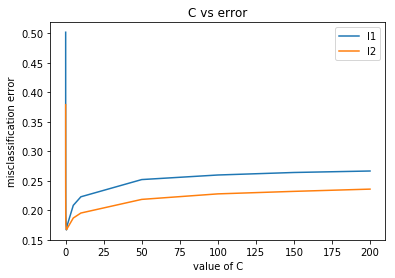

**********************************************************************

accuracy= 86.00333333333333
**********************************************************************

confusion matrix--


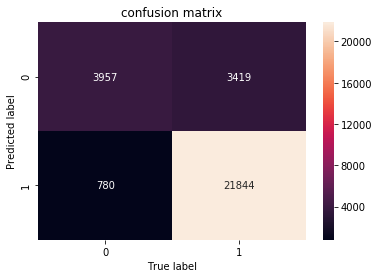

**********************************************************************

TNR= 0.8353388220392653
TPR= 0.8646637374816926
FPR= 0.16466117796073465
FNR= 0.1353362625183074
**********************************************************************

             precision    recall  f1-score   support

          0       0.84      0.54      0.65      7376
          1       0.86      0.97      0.91     22624

avg / total       0.86      0.86      0.85     30000

**********************************************************************



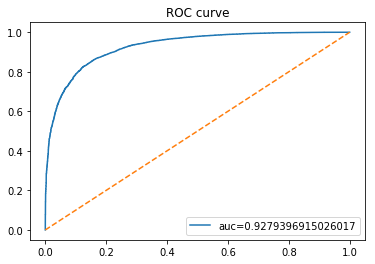

In [91]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

In [483]:
results=pd.DataFrame(columns=['sno.', 'featurization', 'n_gram range', 'model' ,'cv algo', 'best penalty', 'class_weight', 'best C', 'accuracy', 'AUC', 'TNR', 'TPR', 'FPR', 'FNR'])

In [3]:
new=[5,'Tf-Idf', 'unigram', 'LogisticRegression','GridSearchCV', 'l1', 'None', 0.5, 86.0033, 0.9279, 0.8353, 0.8646, 0.1646, 0.1353]
results.loc[4]=new

###  Logistic regression for TfIdf using RandomizedSearchCV

In [93]:
#from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [94]:
# fitting the model
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


duration =  0:02:49.355239


In [95]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 0.5
best penalty= l1


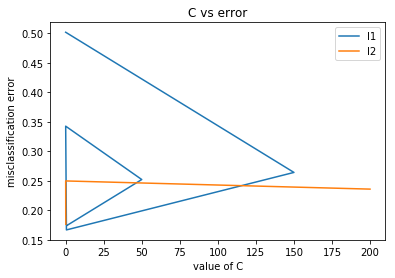

**********************************************************************

accuracy= 86.00333333333333
**********************************************************************

confusion matrix--


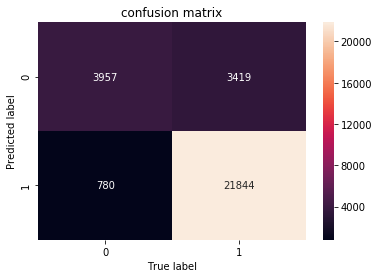

**********************************************************************

TNR= 0.8353388220392653
TPR= 0.8646637374816926
FPR= 0.16466117796073465
FNR= 0.1353362625183074
**********************************************************************

             precision    recall  f1-score   support

          0       0.84      0.54      0.65      7376
          1       0.86      0.97      0.91     22624

avg / total       0.86      0.86      0.85     30000

**********************************************************************



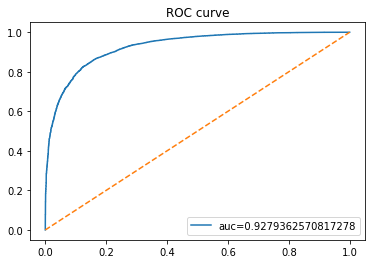

In [96]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

In [4]:
new=[6,'Tf-Idf', 'unigram', 'LogisticRegression','RandomizedSearchCV', 'l1', 'None', 0.5, 86.0033, 0.9279, 0.8353, 0.8646, 0.1646, 0.1353]
results.loc[5]=new

In [8]:
results.iloc[:]

,sno.,featurization,n_gram range,model,cv algo,best penalty,class_weight,best C,accuracy,AUC,TNR,TPR,FPR,FNR
4,5,Tf-Idf,unigram,LogisticRegression,GridSearchCV,l1,None,0.5,86.0033,0.9279,0.8353,0.8646,0.1646,0.1353
5,6,Tf-Idf,unigram,LogisticRegression,RandomizedSearchCV,l1,None,0.5,86.0033,0.9279,0.8353,0.8646,0.1646,0.1353


#### Observation-
* we can choose C=0.5 and penalty='l1' as a best hyperparameter for Tfidf

#### checking sparsity of TfIdf by fixing penalty='l1' and changing C value

In [459]:
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [460]:
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

at C= 0.001
test error= 0.49116666666666664
number of non zero element in w= 2
***********************************************
at C= 0.005
test error= 0.36106666666666665
number of non zero element in w= 27
***********************************************
at C= 0.01
test error= 0.27746666666666664
number of non zero element in w= 68
***********************************************
at C= 0.05
test error= 0.18779999999999997
number of non zero element in w= 308
***********************************************
at C= 0.1
test error= 0.1676333333333333
number of non zero element in w= 527
***********************************************
at C= 0.5
test error= 0.14406666666666668
number of non zero element in w= 1634
***********************************************
at C= 1
test error= 0.13783333333333336
number of non zero element in w= 2728
***********************************************
at C= 5
test error= 0.13239999999999996
number of non zero element in w= 7302
********************************

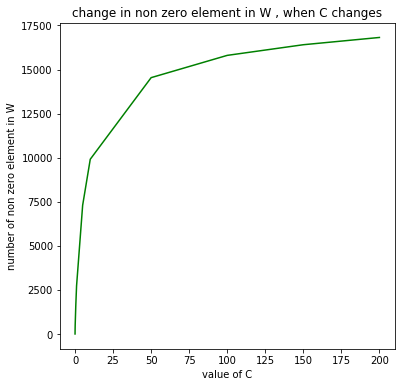

In [446]:
C= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200]
_=sparsity(C, x_train=x_train_bow, x_test=x_test_bow, y_train=y_train, y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

#### feature importance and multicollinearity for TfIdf using best C=0.5 and penalty='l1'

In [486]:
clf=LogisticRegression(C=0.5, penalty='l1')
clf.fit(x_train_tfidf,y_train)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 2333


In [487]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

x_train_tfidf.data=x_train_tfidf.data+np.random.normal(loc=0,scale=0.1,size=x_train_tfidf.data.shape)  #adding a noise with a very small value

In [488]:
clf=LogisticRegression(C=0.5, penalty='l1')
clf.fit(x_train_tfidf,y_train)
w_=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w_))

number of non-zero element in w= 2516


In [489]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 1023


#### Observation-
* we have 2333 non zero elements in weight before perturbation and after perturbation weight
* after perturbation test, 1023 elements in weight before perturbation change by more than 50 %
* Thus we can say that more than half of the elements in weight are collinear
* Thus we can not find feature importance directly by coef_ of model

#### feature importance of TfIdf Logistic regression model using RFE(recursive feature elimination)

In [490]:
%time
from sklearn.feature_selection import RFE
rfe = RFE(clf, 100, verbose=0, step=100)
fit = rfe.fit(x_train_tfidf,y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26 µs


In [491]:
feature=tfidf.get_feature_names()

In [492]:
rank=fit.ranking_
index=[]
for i in range(len(feature)):
    if(rank[i]==1):
        index.append(i)

In [493]:
print('top 100 words comes from RFE and their corresponding weight')
print('*************************************************************')
for i in range(100):
    print(feature[index[i]],'\t\t:\t\t',w[0][index[i]])

top 100 words comes from RFE and their corresponding weight
*************************************************************
addict 		:		 5.724169187681027
amaz 		:		 5.468636916388245
arsenic 		:		 -3.5756639843294753
asham 		:		 -2.8278413083337317
aw 		:		 -7.026113629234895
awesom 		:		 5.9293089776696
bewar 		:		 -3.9868824294108207
bland 		:		 -6.027074726163309
bonus 		:		 4.389457547402588
cancel 		:		 -4.894694449686748
china 		:		 -4.897043841416997
compliment 		:		 3.4851632774373686
contact 		:		 -2.7049743638433363
decept 		:		 -4.935426098459307
defect 		:		 -3.109802245466175
delici 		:		 6.0203348585708865
descript 		:		 -4.719830053176613
diarrhea 		:		 -4.470646934847086
disappoint 		:		 -7.37564333403567
disclos 		:		 -5.013939556367481
disgust 		:		 -5.343638111101076
dissapoint 		:		 -3.9968655522101266
donat 		:		 -4.763961825671378
downsid 		:		 7.08465521309032
drawback 		:		 5.6318383474962035
drizzl 		:		 3.694113723761086
easi 		:		 4.847015608848899
econom 		:	

# 3. Logistic Regression for Avg word2vec

In [211]:
#url for the GoogleNews word2vec model
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [213]:
#downloading the GoogleNews word2vec modelinto the cognitive class disk
import urllib
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")


('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x3ffee1df4208>)

In [201]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [216]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-09-10 05:45:12,840 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-10 05:48:08,973 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [220]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        w=w.decode('utf-8')
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [222]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [223]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [224]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[519, 18040, 46231, 59833, 99521, 99525, 99563, 114788, 115663]

In [225]:
vectors=np.delete(vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [228]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        word=word.decode('utf-8')
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [237]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[11047]

In [238]:
#deleting row containing nan value
x_test_word=np.delete(x_test_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

In [240]:
# applying column standardization on every columns
from sklearn.preprocessing import StandardScaler
s=StandardScaler()
vectors=s.fit_transform(vectors)
x_test_word=s.fit_transform(x_test_word)

###  Logistic regression for avg word2vec using GridSearchCV 

In [244]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,1000], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [ ]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 21.5min finished


duration =  0:21:40.180010


In [246]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 0.001
best penalty= l2


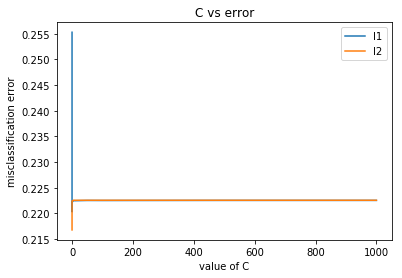

**********************************************************************

accuracy= 62.36541218040601
**********************************************************************

confusion matrix--


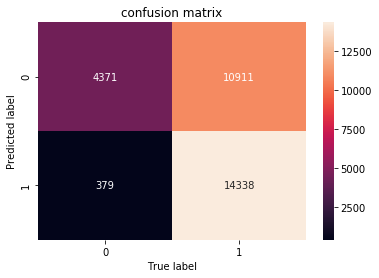

**********************************************************************

TNR= 0.9202105263157895
TPR= 0.5678640738247059
FPR= 0.07978947368421052
FNR= 0.43213592617529406
**********************************************************************

             precision    recall  f1-score   support

          0       0.92      0.29      0.44     15282
          1       0.57      0.97      0.72     14717

avg / total       0.75      0.62      0.57     29999

**********************************************************************



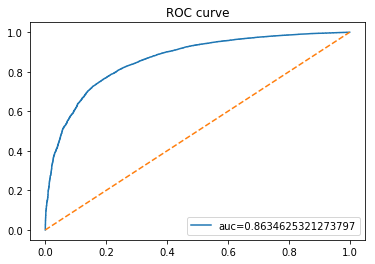

In [247]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

In [248]:
word_res=pd.DataFrame(columns=['sno.', 'featurization', 'n_gram range', 'model' ,'cv algo', 'best penalty', 'class_weight', 'best C', 'accuracy', 'AUC', 'TNR', 'TPR', 'FPR', 'FNR'])

In [249]:
new=[1,'Avg word2vec', '-', 'LogisticRegression','GridSearchCV',penalty, 'None', c, accu, auc, TNR, TPR, FPR, FNR]
word_res.loc[0]=new

###  Logistic regression for avg word2vec using RandomizedSearchCV

In [250]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
c=np.random.uniform(0,100,size=10)
c=[round(x,3) for x in c]
param={'C': c, 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [251]:
# fitting the model
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.6 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.5min finished


duration =  0:08:39.220844


In [252]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 11.593
best penalty= l1


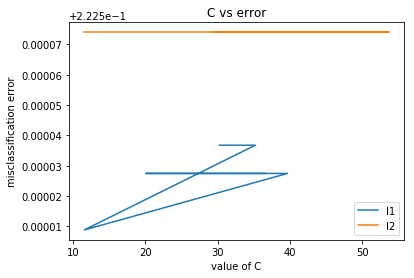

**********************************************************************

accuracy= 62.492083069435644
**********************************************************************

confusion matrix--


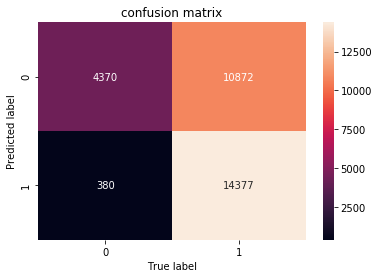

**********************************************************************

TNR= 0.92
TPR= 0.5694086894530477
FPR= 0.08
FNR= 0.4305913105469524
**********************************************************************

             precision    recall  f1-score   support

          0       0.92      0.29      0.44     15242
          1       0.57      0.97      0.72     14757

avg / total       0.75      0.62      0.58     29999

**********************************************************************



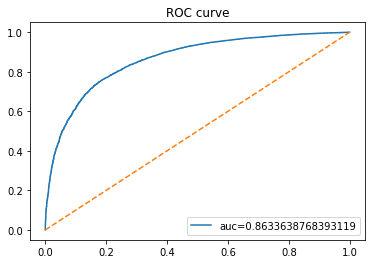

In [253]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

In [254]:
new=[2,'Avg word2vec', '-', 'LogisticRegression','RandomizedSearchCV',penalty, 'None', c, accu, auc, TNR, TPR, FPR, FNR]
word_res.loc[1]=new

In [469]:
word_res

,sno.,featurization,n_gram range,model,cv algo,best penalty,class_weight,best C,accuracy,AUC,TNR,TPR,FPR,FNR
0,1,Avg word2vec,-,LogisticRegression,GridSearchCV,l2,None,0.001,62.365412,0.863463,0.920211,0.567864,0.079789,0.432136
1,2,Avg word2vec,-,LogisticRegression,RandomizedSearchCV,l1,None,11.593,62.492083,0.863364,0.920000,0.569409,0.080000,0.430591


#### checking sparsity of avg word2vec by fixing penalty='l1' and changing C value

at C= 1e-05
test error= 0.8416613887129571
number of non zero element in w= 0
***********************************************
at C= 0.0001
test error= 0.4280476015867195
number of non zero element in w= 7
***********************************************
at C= 0.0005
test error= 0.4069802326744225
number of non zero element in w= 70
***********************************************
at C= 0.001
test error= 0.4006800226674222
number of non zero element in w= 114
***********************************************
at C= 0.005
test error= 0.37804593486449545
number of non zero element in w= 231
***********************************************
at C= 0.01
test error= 0.3756458548618288
number of non zero element in w= 263
***********************************************
at C= 0.05
test error= 0.37497916597219905
number of non zero element in w= 293
***********************************************
at C= 0.1
test error= 0.37537917930597686
number of non zero element in w= 298
****************************

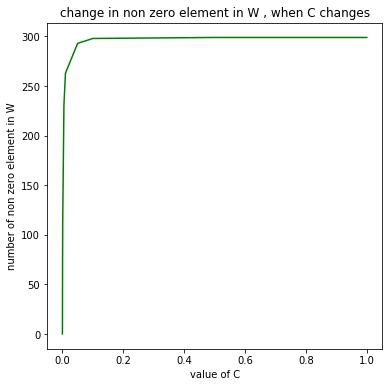

In [499]:
C= [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
_=sparsity(C, x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

#### feature importance and multicollinearity for avg word2vec using the best C=0.001 and penalty='l2'

In [501]:
clf=LogisticRegression(C=0.001, penalty='l2')
clf.fit(vectors,y_train_word)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 300


In [502]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

vectors.data=vectors.data+np.random.normal(loc=0,scale=0.1,size=vectors.data.shape)  #adding a noise with a very small value

In [503]:
clf=LogisticRegression(C=0.001, penalty='l2')
clf.fit(vectors,y_train_word)
w_=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 300


In [510]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 10


In [513]:
print('top 10 elements of weight--')
print('******************************')
np.sort(w)[0][-10:]

top 10 elements of weight--
******************************


array([0.14339076, 0.14778864, 0.15033057, 0.17130161, 0.17289956,
       0.18027462, 0.18979618, 0.20088777, 0.23127525, 0.30617542])

#### Observation-
* only 10 in 300 elements having change more than 50 %, we may not put in collinear category
* we can't find the important words in avg word2vec

# 4. Logistic Regression for TfIdf word2vec

In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [256]:
features=tfidf.get_feature_names()
len(features)
#features

28021

In [257]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [258]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[519, 18040, 46231, 59833, 99521, 99525, 99563, 114788, 115663]

In [259]:

y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)



In [266]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        word=word.decode('utf-8')
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [268]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[11047]

In [269]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

29999

In [270]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(x_test_word)

29999

In [271]:
s=StandardScaler()
tfidf_vectors=s.fit_transform(tfidf_vectors)
x_test_tf_word=s.transform(x_test_tf_word)

###  Logistic regression for TfIdf word2vec using GridSearchCV

In [272]:

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,1000], 'penalty':penalty}
clf=LogisticRegression()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [273]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 19.2min finished


duration =  0:19:22.179353


In [274]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 0.001
best penalty= l2


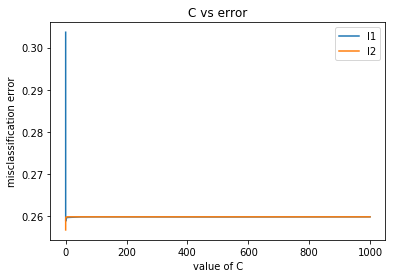

**********************************************************************

accuracy= 60.698689956331876
**********************************************************************

confusion matrix--


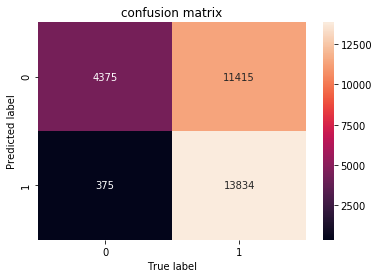

**********************************************************************

TNR= 0.9210526315789473
TPR= 0.5479028872430591
FPR= 0.07894736842105263
FNR= 0.45209711275694087
**********************************************************************

             precision    recall  f1-score   support

          0       0.92      0.28      0.43     15790
          1       0.55      0.97      0.70     14209

avg / total       0.74      0.61      0.56     29999

**********************************************************************



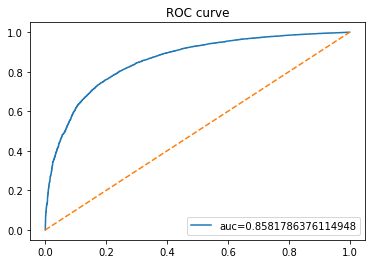

In [275]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

In [9]:
new=[7,'Tf-Idf Word2vec', '---', 'LogisticRegression','GridSearchCV', 'l2', 'None', 0.001, 60.6986, 0.8581, 0.9210, 0.5479, 0.0789, 0.4520]
results.loc[6]=new

###  Logistic regression for TfIdf word2vec using RandomizedSearchCV

In [276]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
tscv=TimeSeriesSplit(n_splits=10)
penalty=['l2','l1']
c=np.random.uniform(0,100,size=10)
c=[round(x,3) for x in c]
param={'C': c, 'penalty':penalty}
clf=LogisticRegression()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param, cv=tscv,  verbose=1)

In [277]:
# fitting the model
%time
start=datetime.now()
clf.fit(tfidf_vectors,y_train_word)
#pickle.dump(clf,open('bow_bigram_balanced_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.3min finished


duration =  0:08:23.228648


In [278]:
# best value of C
c=clf.best_estimator_.get_params()['C']
penalty=clf.best_estimator_.get_params()['penalty']
print('best C=',c)
print('best penalty=',penalty)

best C= 13.79
best penalty= l1


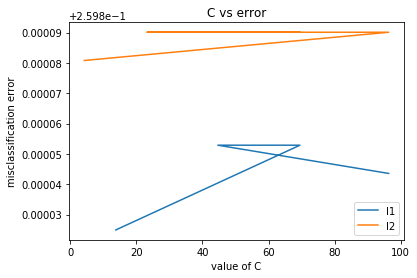

**********************************************************************

accuracy= 60.83536117870596
**********************************************************************

confusion matrix--


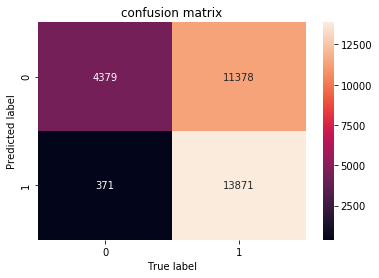

**********************************************************************

TNR= 0.9218947368421052
TPR= 0.5493682918135372
FPR= 0.07810526315789473
FNR= 0.4506317081864628
**********************************************************************

             precision    recall  f1-score   support

          0       0.92      0.28      0.43     15757
          1       0.55      0.97      0.70     14242

avg / total       0.75      0.61      0.56     29999

**********************************************************************



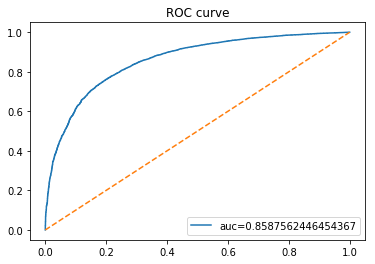

In [279]:
accu, auc, TNR, TPR, FPR, FNR=logistic_regression(clf=clf, x_train=tfidf_vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

In [10]:
new=[8,'Tf-Idf Word2vec', '---', 'LogisticRegression','RandimizedSearchCV', 'l1', 'None', 13.79, 60.8353, 0.8587, 0.9218, 0.5493, 0.0781, 0.4506]
results.loc[7]=new

In [12]:
results.iloc[2:]

,sno.,featurization,n_gram range,model,cv algo,best penalty,class_weight,best C,accuracy,AUC,TNR,TPR,FPR,FNR
6,7,Tf-Idf Word2vec,---,LogisticRegression,GridSearchCV,l2,None,0.001,60.6986,0.8581,0.9210,0.5479,0.0789,0.4520
7,8,Tf-Idf Word2vec,---,LogisticRegression,RandimizedSearchCV,l1,None,13.790,60.8353,0.8587,0.9218,0.5493,0.0781,0.4506


#### Observation-
* we can choose C=0.001 and  penalty='l2' as a best hyperparameter for Tfidf word2vec

#### checking sparsity of TfIdf word2vec by fixing penalty='l1' and changing C value

at C= 1e-05
test error= 0.8416613887129571
number of non zero element in w= 0
***********************************************
at C= 0.0001
test error= 0.8416613887129571
number of non zero element in w= 0
***********************************************
at C= 0.0005
test error= 0.293009766992233
number of non zero element in w= 73
***********************************************
at C= 0.001
test error= 0.27634254475149167
number of non zero element in w= 130
***********************************************
at C= 0.005
test error= 0.2583419447314911
number of non zero element in w= 243
***********************************************
at C= 0.01
test error= 0.25687522917430583
number of non zero element in w= 267
***********************************************
at C= 0.05
test error= 0.25444181472715754
number of non zero element in w= 298
***********************************************
at C= 0.1
test error= 0.25407513583786123
number of non zero element in w= 298
****************************

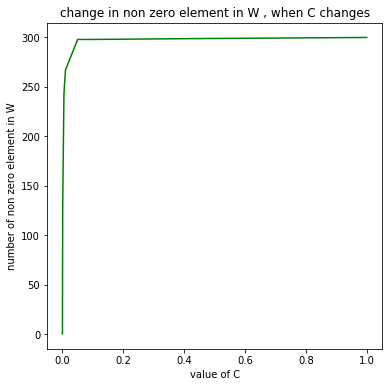

In [516]:
C= [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
_=sparsity(C, x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

#### feature importance and multicollinearity for avg word2vec using the best C=0.001 and penalty='l2'

In [517]:
clf=LogisticRegression(C=0.001, penalty='l2')
clf.fit(tfidf_vectors,y_train_word)
w=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 300


In [519]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

tfidf_vectors.data=tfidf_vectors.data+np.random.normal(loc=0,scale=0.1,size=tfidf_vectors.data.shape)  #adding a noise with a very small value

In [520]:
clf=LogisticRegression(C=0.001, penalty='l2')
clf.fit(tfidf_vectors,y_train_word)
w_=clf.coef_
print('number of non-zero element in w=', np.count_nonzero(w))

number of non-zero element in w= 300


In [521]:
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta, more than 50 %=',cnt)

number of elements in w_delta, more than 50 %= 9


In [522]:
print('top 10 elements of weight--')
print('******************************')
np.sort(w)[0][-10:]

top 10 elements of weight--
******************************


array([0.13685716, 0.13742999, 0.13803844, 0.13998543, 0.15602981,
       0.16683909, 0.17285568, 0.19956285, 0.20550917, 0.26470741])

#### Observation-
* only 9 in 300 elements having change more than 50 %, we may not put in collinear category
* we can't find the important words in TfIdf word2vec

In [13]:
print('Final Table')

Final Table


| Featurization  	| CV Algo            	| Best C 	| Best penalty 	| Accuracy 	| TNR    	| TPR    	|
|----------------	|--------------------	|--------	|--------------	|----------	|--------	|--------	|
| BOW            	| GridSearchCV       	| 1      	| l2           	| 86.3133  	| 0.8383 	| 0.8676 	|
| BOW            	| RandomizedSearchCV 	| 1      	| l2           	| 86.3133  	| 0.8383 	| 0.8676 	|
| TfIdf          	| GridSearchCV       	| 0.5    	| l1           	| 86.0033  	| 0.8353 	| 0.8646 	|
| TfIdf          	| RandomizedSearchCV 	| 0.5    	| l1           	| 86.0033  	| 0.8353 	| 0.8646 	|
| Avg Word2Vec   	| GridSearchCV       	| 0.001  	| l2           	| 62.3654  	| 0.9202 	| 0.5678 	|
| Avg Word2Vec   	| RandomizedSearchCV 	| 11.593 	| l1           	| 62.4920  	| 0.92   	| 0.5694 	|
| TfIdf Word2Vec 	| GridSearchCV       	| 0.001  	| l2           	| 60.6986  	| 0.9210 	| 0.5479 	|
| TfIdf Word2Vec 	| RandomizedSearchCV 	| 13.79  	| l1           	| 60.8353  	| 0.9218 	| 0.5493 	|

# Conclusion-
* we have taken amazon fine food review and applied logistic regression model using BoW, Tfidf, Avg word2vec and Tfidf word2vec.
* This dataset is imbalanced so we have applied upsampling on top of it.
* in the final table we can see that Logistic regression works well for BOW and TFIDF, but not good in case of avg word2vec and tfidf word2vec.
* we can conclude that logistic regression works fairly well if dimension is high